In [2]:
import numpy as np
import random
import string # to process standard python strings
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import json
import pickle
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

In [3]:
for dirname, _, filenames in os.walk('/home/ashioyajotham/luna/chatbot'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/ashioyajotham/luna/chatbot/intents.json
/home/ashioyajotham/luna/chatbot/app1.py
/home/ashioyajotham/luna/chatbot/__pycache__/app.cpython-311.pyc
/home/ashioyajotham/luna/chatbot/templates/chatbot.html
/home/ashioyajotham/luna/chatbot/templates/index.html


In [4]:
import json

with open('/home/ashioyajotham/luna/chatbot/intents.json') as json_data:
    intents = json.load(json_data)

df = pd.DataFrame(intents['intents'])
df.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(df['patterns'])
tokenizer.get_config()

vacab_size = len(tokenizer.word_index)
print('number of unique words = ', vacab_size)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

ptrn2seq = tokenizer.texts_to_sequences(df['patterns'])
X = pad_sequences(ptrn2seq, padding='post')
print('X shape = ', X.shape)

lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df['tag'])
print('y shape = ', y.shape)
print('num of classes = ', len(np.unique(y)))

classes = lbl_enc.classes_
#print(classes)

words = tokenizer.word_index
#print(words)

2023-02-26 06:08:12.495613: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-02-26 06:08:12.576376: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-02-26 06:08:14.867965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


number of unique words =  231
X shape =  (80, 12)
y shape =  (80,)
num of classes =  80


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 100)           23200     
                                                                 
 lstm (LSTM)                 (None, 12, 32)            17024     
                                                                 
 layer_normalization (LayerN  (None, 12, 32)           64        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            8320      
                                                                 
 layer_normalization_1 (Laye  (None, 12, 32)           64        
 rNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 32)                8

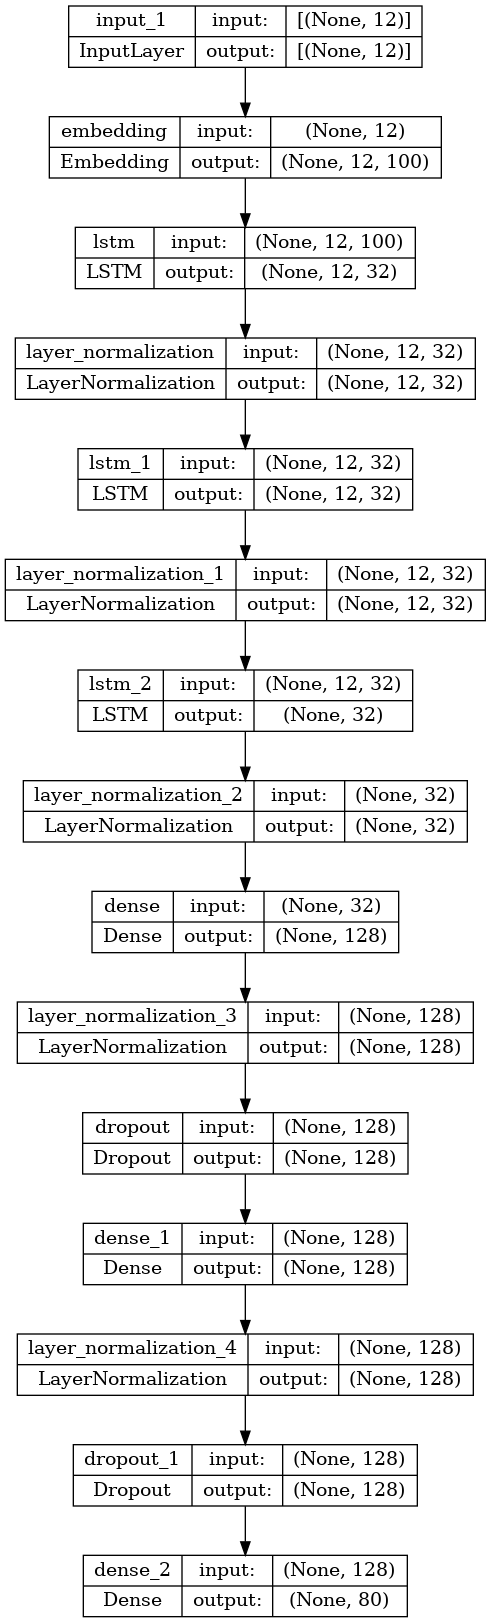

In [6]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout
from tensorflow.keras.utils import plot_model

model = Sequential()
model.add(Input(shape=(X.shape[1])))
model.add(Embedding(input_dim=vacab_size+1, output_dim=100, mask_zero=True))
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32))
model.add(LayerNormalization())
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(y)), activation="softmax"))
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

In [7]:
model_history = model.fit(x=X,
                          y=y,
                          batch_size=10,
                          callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)],
                          epochs=10)

Epoch 1/10
8/8 [==============================] - 30s 29ms/step - loss: 5.3487 - accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 0s 24ms/step - loss: 3.9191 - accuracy: 0.1125
Epoch 3/10
8/8 [==============================] - 0s 24ms/step - loss: 3.1430 - accuracy: 0.2125
Epoch 4/10
8/8 [==============================] - 0s 24ms/step - loss: 2.4050 - accuracy: 0.4750
Epoch 5/10
8/8 [==============================] - 0s 22ms/step - loss: 1.9460 - accuracy: 0.7000
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 1.6310 - accuracy: 0.8250
Epoch 7/10
8/8 [==============================] - 0s 22ms/step - loss: 1.3697 - accuracy: 0.9125
Epoch 8/10
8/8 [==============================] - 0s 24ms/step - loss: 1.1087 - accuracy: 0.9250
Epoch 9/10
8/8 [==============================] - 0s 27ms/step - loss: 1.0354 - accuracy: 0.9625
Epoch 10/10
8/8 [==============================] - 0s 25ms/step - loss: 0.7268 - accuracy: 0.9875


In [8]:
import re
import random

def generate_answer(pattern): 
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', pattern)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)
        
    x_test = tokenizer.texts_to_sequences(text)
    x_test = np.array(x_test).squeeze()
    x_test = pad_sequences([x_test], padding='post', maxlen=X.shape[1])
    y_pred = model.predict(x_test)
    y_pred = y_pred.argmax()
    tag = lbl_enc.inverse_transform([y_pred])[0]
    responses = df[df['tag'] == tag]['responses'].values[0]

    print("you: {}".format(pattern))
    print("model: {}".format(random.choice(responses)))

In [9]:
generate_answer("what is your name?")

1/1 [==============================] - 12s 12s/step
you: what is your name?
model: Next, I would suggest you to practice meditation. Meditation can produce a deep state of relaxation and a tranquil mind.


In [10]:
generate_answer("I am feeling happy")

1/1 [==============================] - 0s 44ms/step
you: I am feeling happy
model: Next, I would suggest you to practice meditation. Meditation can produce a deep state of relaxation and a tranquil mind.


In [11]:
generate_answer("I am feeling sad")

1/1 [==============================] - 0s 60ms/step
you: I am feeling sad
model: Next, I would suggest you to practice meditation. Meditation can produce a deep state of relaxation and a tranquil mind.


In [12]:
generate_answer("Good morning")

1/1 [==============================] - 0s 43ms/step
you: Good morning
model: Next, I would suggest you to practice meditation. Meditation can produce a deep state of relaxation and a tranquil mind.


In [13]:
# Get the shapes of each layer
for layer in model.layers:
    print(layer.name, layer.output_shape)

embedding (None, 12, 100)
lstm (None, 12, 32)
layer_normalization (None, 12, 32)
lstm_1 (None, 12, 32)
layer_normalization_1 (None, 12, 32)
lstm_2 (None, 32)
layer_normalization_2 (None, 32)
dense (None, 128)
layer_normalization_3 (None, 128)
dropout (None, 128)
dense_1 (None, 128)
layer_normalization_4 (None, 128)
dropout_1 (None, 128)
dense_2 (None, 80)
